<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/mrk-W2D1/tutorials/W2D1_BayesianStatistics/student/W2D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT,force_remount=True)       

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Neuromatch Academy: Week 2, Day 1, Tutorial 1
# Bayes rule with Gaussians

__Content creators:__ Vincent Valton, Konrad Kording, with help from Matt Krause

__Content reviewers:__ Matt Krause, Jesse Livezey, Karolina Stosio, Saeed Salehi, Michael Waskom

# Tutorial Objectives
This is the first in a series of three main tutorials (+ one bonus tutorial) on Bayesian statistics. In these tutorials, we will develop a Bayesian model for localizing sounds based on audio and visual cues. This model will combine **prior** information about where sounds generally originate with sensory information about the **likelihood** that a specific sound came from a particular location. As we will see in subsequent lessons, the resulting **posterior distribution** not only allows us to make optimal decision about the sound's origin, but also lets us quantify how uncertain that decision is. Bayesian techniques are therefore useful **normative models**: the behavior of human or animal subjects can be compared against these models to determine how efficiently they make use of information. 

This notebook will introduce two fundamental building blocks for Bayesian statistics: the Gaussian distribution and the Bayes Theorem. You will: 

1. Implement a Gaussian distribution
2. Use Bayes' Theorem to find the posterior from a Gaussian-distributed prior and likelihood. 
3. Change the likelihood mean and variance and observe how posterior changes.
4. Advanced (*optional*): Observe what happens if the prior is a mixture of two gaussians?


Video available at https://youtube.com/watch?v=K4sSKZtk-Sc


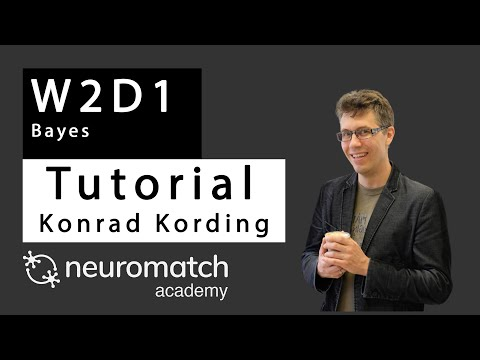

In [ ]:
#@title Video 1: Introduction to Bayesian Statistics
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='K4sSKZtk-Sc', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Setup  
Please execute the cells below to initialize the notebook environment.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#@title Figure Settings
import ipywidgets as widgets
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
#@title Helper functions
def my_plot_single(x, px):
    """
    Plots normalized Gaussian distribution
    
    Args:
        x (numpy array of floats):     points at which the likelihood has been evaluated
        px (numpy array of floats):    normalized probabilities for prior evaluated at each `x`
             
    Returns:
        Nothing.
    """
    if px is None:
        px = np.zeros_like(x)

    fig, ax = plt.subplots()
    ax.plot(x, px, '-', color='xkcd:green', LineWidth=2, label='Prior')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')


def posterior_plot(x, likelihood=None, prior=None, posterior_pointwise=None, ax=None):
    """
    Plots normalized Gaussian distributions and posterior 
    
    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        auditory (numpy array of floats):  normalized probabilities for auditory likelihood evaluated at each `x`
        visual (numpy array of floats):    normalized probabilities for visual likelihood evaluated at each `x`
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
        ax: Axis in which to plot. If None, create new axis. 
  
    Returns:
        Nothing.
    """
    if likelihood is None:
        likelihood = np.zeros_like(x)

    if prior is None:
        prior = np.zeros_like(x)

    if posterior_pointwise is None:
        posterior_pointwise = np.zeros_like(x)
  
    if ax is None:
      fig, ax = plt.subplots()

    ax.plot(x, likelihood, '-r', LineWidth=2, label='Auditory')
    ax.plot(x, prior, '-b', LineWidth=2, label='Visual')
    ax.plot(x, posterior_pointwise, '-g', LineWidth=2, label='Posterior')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')

    return ax


def plot_visual(mu_visuals, mu_posteriors, max_posteriors):
    """
    Plots the comparison of computing the mean of the posterior analytically and
    the max of the posterior empirically via multiplication.
    
    Args:
        mu_visuals (numpy array of floats): means of the visual likelihood
        mu_posteriors (numpy array of floats):  means of the posterior, calculated analytically
        max_posteriors (numpy array of floats): max of the posteriors, calculated via maxing the max_posteriors.
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
        
    Returns:
        Nothing.
    """
    fig_w, fig_h = plt.rcParams.get('figure.figsize')
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(fig_w, 2 * fig_h))

    ax[0].plot(mu_visuals, max_posteriors, '-g', label='mean')
    ax[0].set_xlabel('Visual stimulus position')
    ax[0].set_ylabel('Multiplied posterior mean')
    ax[0].set_title('Sample output')

    ax[1].plot(mu_visuals, mu_posteriors, '--', color='xkcd:gray', label='argmax')
    ax[1].set_xlabel('Visual stimulus position')
    ax[1].set_ylabel('Analytical posterior mean')
    fig.tight_layout()
    ax[1].set_title('Hurray for math!')


def multimodal_plot(x, example_prior, example_likelihood,
                    mu_visuals, posterior_modes):
  """Helper function for plotting Section 4 results"""

  fig_w, fig_h = plt.rcParams.get('figure.figsize')
  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(fig_w, 2*fig_h), sharex=True)

  # Plot the last instance that we tried.
  posterior_plot(x,
    example_prior,
    example_likelihood,
    compute_posterior_pointwise(example_prior, example_likelihood),
    ax=ax[0]
    )
  ax[0].set_title('Example combination')

  ax[1].plot(mu_visuals, posterior_modes, '-g', label='argmax')
  ax[1].set_xlabel('Visual stimulus position\n(Mean of blue dist. above)')
  ax[1].set_ylabel('Posterior mode\n(Peak of green dist. above)')
  fig.tight_layout()

# Section 1: The Gaussian Distribution

Bayesian analysis operates on probability distributions. Although these can take many forms, the Gaussian distribution is a very common choice. Because of the central limit theorem, many quantities are Gaussian-distributed. Gaussians also have some mathematical properties that permit simple closed-form solutions to several important problems. 

In this exercise, you will implement a Gaussian by filling in the missing portion of `my_gaussian` below. Gaussians have two parameters. The **mean** $\mu$, which sets the location of its center. Its "scale" or spread is controlled by its **standard deviation** $\sigma$ or its square, the **variance** $\sigma^2$. (Be careful not to use one when the other is required). 

The equation for a Gaussian is:
$$
\mathcal{N}(\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)
$$
Also, don't forget that this is a probability distribution and should therefore sum to one. While this happens "automatically" when integrated from $-\infty$ to $\infty$, your version will only be computed over a finite number of points. You therefore need to explicitly normalize it yourself. 

Test out your implementation with a $\mu = -1$ and $\sigma = 1$. After you have it working, play with the  parameters to develop an intuition for how changing $\mu$ and $\sigma$ alter the shape of the Gaussian. This is important, because subsequent exercises will be built out of Gaussians. 

## Exercise 1: Implement a Gaussian

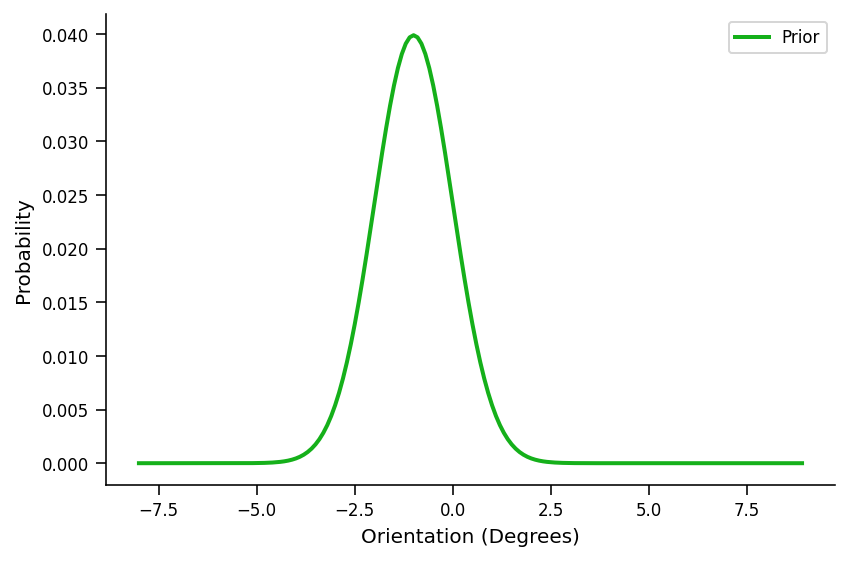

In [7]:
def my_gaussian(x_points, mu, sigma):
    """
    Returns normalized Gaussian estimated at points `x_points`, with parameters:
     mean `mu` and std `sigma`
    
    Args:
        x_points (numpy array of floats): points at which the gaussian is
                                          evaluated
        mu (scalar): mean of the Gaussian
        sigma (scalar): std of the gaussian
    
    Returns: 
        (numpy array of floats) : normalized Gaussian evaluated at `x`
    """

    ###################################################################
    ## Add code to calcualte the gaussian px as a function of mu and sigma, 
    ## for every x in x_points
    ## Function Hints: exp -> np.exp()
    ##                 power -> z**2
    ## remove the raise below to test your function
    #raise NotImplementedError("You need to implement the Gaussian function!")
    ################################################################### 
    px = np.exp(-(x_points-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
    px /= np.sum(px)

    return px


x = np.arange(-8, 9, 0.1)

# Uncomment to plot the results
px = my_gaussian(x, -1, 1)
my_plot_single(x, px)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial1_Solution_aeeeaedf.py)

*Example output:*

<img alt='Solution hint' align='left' width=424 height=280 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial1_Solution_aeeeaedf_2.png>



# Section 2. Bayes' Theorem and the Posterior

Video available at https://youtube.com/watch?v=ewQPHQMcdBs


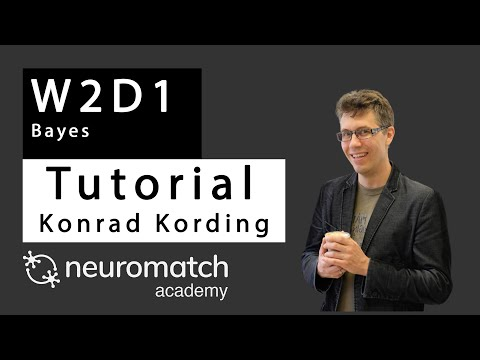

In [ ]:
#@title Video 2: Bayes' theorem
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='ewQPHQMcdBs', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video



Bayes' rule tells us how to combine two sources of information: the prior (e.g., a noisy representation of our expectations about where the stimulus might come from) and the likelihood (e.g., a noisy representation of the stimulus position on a given trial), to obtain a posterior distribution taking into account both pieces of information. Bayes' rule states:

\begin{eqnarray}
\text{Posterior} = \frac{ \text{Likelihood} \times \text{Prior}}{ \text{Normalization constant}}
\end{eqnarray}

When both the prior and likelihood are Gaussians, this translates into the following form:

$$
\begin{array}{rcl}
\text{Likelihood} &=& \mathcal{N}(\mu_{likelihood},\sigma_{likelihood}^2) \\
\text{Prior} &=& \mathcal{N}(\mu_{prior},\sigma_{prior}^2) \\
\text{Posterior} &\propto& \mathcal{N}(\mu_{likelihood},\sigma_{likelihood}^2) \times \mathcal{N}(\mu_{prior},\sigma_{prior}^2) \\
&&= \mathcal{N}\left( \frac{\sigma^2_{likelihood}\mu_{prior}+\sigma^2_{prior}\mu_{likelihood}}{\sigma^2_{likelihood}+\sigma^2_{prior}}, \frac{\sigma^2_{likelihood}\sigma^2_{prior}}{\sigma^2_{likelihood}+\sigma^2_{prior}} \right) 
\end{array}
$$

In these equations, $\mathcal{N}(\mu,\sigma^2)$ denotes a Gaussian distribution with parameters $\mu$ and $\sigma^2$:
$$
\mathcal{N}(\mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \; \exp \bigg( \frac{-(x-\mu)^2}{2\sigma^2} \bigg)
$$

In Exercise 2A, we will use the first form of the posterior, where the two distributions are combined via pointwise multiplication.  Although this method requires more computation, it works for any type of probability distribution. In Exercise 2B, we will see that the closed-form solution shown on the line below produces the same result. 

## Exercise 2A: Finding the posterior computationally

Imagine an experiment where participants estimate the location of a noise-emitting object. To estimate its position, the participants can use two sources of information: 
  1. new noisy auditory information (the likelihood)
  2. prior visual expectations of where the stimulus is likely to come from (visual prior). 

The auditory and visual information are both noisy, so participants will combine these sources of information to better estimate the position of the object.

We will use Gaussian distributions to represent the auditory likelihood (in red), and a Gaussian visual prior (expectations - in blue). Using Bayes rule, you will combine them into a posterior distribution that summarizes the probability that the object is in each location. 

We have provided you with a ready-to-use plotting function, and a code skeleton.

* Use `my_gaussian`, the answer to exercise 1, to generate an auditory likelihood with parameters $\mu$ = 3 and $\sigma$ = 1.5
* Generate a visual prior with parameters $\mu$ = -1 and $\sigma$ = 1.5
* Calculate the posterior using pointwise multiplication of the likelihood and prior. Don't forget to normalize so the posterior adds up to 1. 
* Plot the likelihood, prior and posterior using the predefined function `posterior_plot`



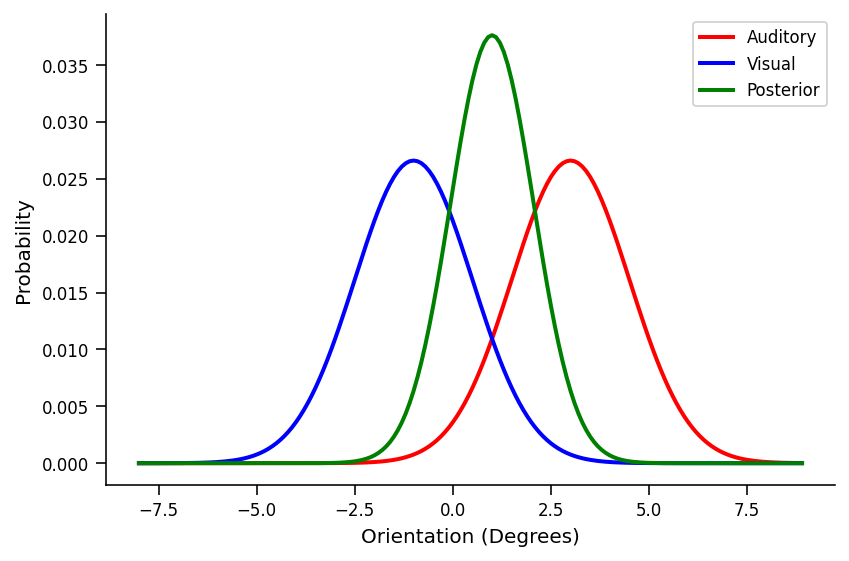

In [8]:
def compute_posterior_pointwise(prior, likelihood):
  ##############################################################################
  # Write code to compute the posterior from the prior and likelihood via
  # pointwise multiplication. (You may assume both are defined over the same x-axis)
  #
  # Comment out the line below to test your solution
  #raise NotImplementedError("Finish the simulation code first")
  ##############################################################################
  posterior = prior*likelihood
  posterior /= np.sum(posterior)

  return posterior


def localization_simulation(mu_auditory=3.0, sigma_auditory=1.5,
                            mu_visual=-1.0, sigma_visual=1.5):
  
  ##############################################################################
  ## Using the x variable below,
  ##      create a gaussian called 'auditory' with mean 3, and std 1.5
  ##      create a gaussian called 'visual' with mean -1, and std 1.5
  #
  #
  ## Comment out the line below to test your solution
  #raise NotImplementedError("Finish the simulation code first")
  ###############################################################################
  x = np.arange(-8, 9, 0.1)

  auditory = my_gaussian(x,mu_auditory,sigma_auditory)
  visual = my_gaussian(x,mu_visual,sigma_visual)
  posterior = compute_posterior_pointwise(auditory, visual)

  return x, auditory, visual, posterior


# Uncomment the lines below to plot the results
x, auditory, visual, posterior_pointwise = localization_simulation()
posterior_plot(x, auditory, visual, posterior_pointwise)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial1_Solution_39d14917.py)

*Example output:*

<img alt='Solution hint' align='left' width=424 height=280 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial1_Solution_39d14917_1.png>



## Interactive Demo: What affects the posterior?

Now that we can compute the posterior of two Gaussians with *Bayes rule*, let's vary the parameters of those Gaussians to see how changing the prior and likelihood affect the posterior. 

**Hit the Play button or Ctrl+Enter in the cell below** and play with the sliders to get an intuition for how the means and standard deviations of prior and likelihood influence the posterior.

When does the prior have the strongest influence over the posterior? When is it the weakest?  

In [9]:
#@title
#@markdown Make sure you execute this cell to enable the widget!

x = np.arange(-10, 11, 0.1)

import ipywidgets as widgets

def refresh(mu_auditory=3, sigma_auditory=1.5, mu_visual=-1, sigma_visual=1.5):
    auditory = my_gaussian(x, mu_auditory, sigma_auditory)
    visual = my_gaussian(x, mu_visual, sigma_visual)
    posterior_pointwise = visual * auditory
    posterior_pointwise /= posterior_pointwise.sum()

    w_auditory = (sigma_visual** 2) / (sigma_auditory**2 + sigma_visual**2)
    theoretical_prediction = mu_auditory * w_auditory + mu_visual * (1 - w_auditory)

    ax = posterior_plot(x, auditory, visual, posterior_pointwise)
    ax.plot([theoretical_prediction, theoretical_prediction], 
            [0, posterior_pointwise.max() * 1.2], '-.', color='xkcd:medium gray')
    ax.set_title(f"Gray line shows analytical mean of posterior: {theoretical_prediction:0.2f}")
    plt.show()

style = {'description_width': 'initial'}

_ = widgets.interact(refresh, 
    mu_auditory=widgets.FloatSlider(value=2, min=-10, max=10, step=0.5, description="mu_auditory:", style=style),
    sigma_auditory=widgets.FloatSlider(value=0.5, min=0.5, max=10, step=0.5, description="sigma_auditory:", style=style),
    mu_visual=widgets.FloatSlider(value=-2, min=-10, max=10, step=0.5, description="mu_visual:", style=style),
    sigma_visual=widgets.FloatSlider(value=0.5, min=0.5, max=10, step=0.5, description="sigma_visual:", style=style)
)

interactive(children=(FloatSlider(value=2.0, description='mu_auditory:', max=10.0, min=-10.0, step=0.5, style=…

## Video 3: Multiplying Gaussians

Video available at https://youtube.com/watch?v=AbXorOLBrws


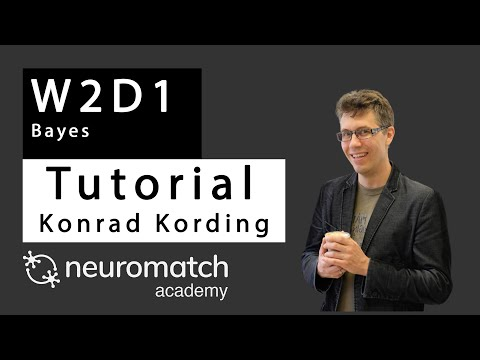

In [ ]:
#@title
from IPython.display import YouTubeVideo

video = YouTubeVideo(id='AbXorOLBrws', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Exercise 2B: Finding the posterior analytically

[If you are running short on time, feel free to skip the coding exercise below].

As you may have noticed from the interactive demo, the product of two Gaussian distributions, like our prior and likelihood, remains a Gaussian, regardless of the parameters. We can directly compute the  parameters of that Gaussian from the means and variances of the prior and likelihood. For example, the posterior mean is given by:

$$ \mu_{posterior} = \frac{\mu_{auditory} \cdot \frac{1}{\sigma_{auditory}^2} + \mu_{visual} \cdot \frac{1}{\sigma_{visual}^2}}{1/\sigma_{auditory}^2 + 1/\sigma_{visual}^2} 
$$

This formula is a special case for two Gaussians, but is a very useful one because:
*   The posterior has the same form (here, a normal distribution) as the prior, and
*   There is simple, closed-form expression for its parameters.

When these properties hold, we call them **conjugate distributions** or **conjugate priors** (for a particular likelihood). Working with conjugate distributions is very convenient; otherwise, it is often necessary to use computationally-intensive numerical methods to combine the prior and likelihood. 

In this exercise, we ask you to verify that property.  To do so, we will hold our auditory likelihood constant as an $\mathcal{N}(3, 1.5)$ distribution, while considering visual priors with different means ranging from $\mu=-10$ to $\mu=10$. For each prior,

* Compute the posterior distribution using the function you wrote in Exercise 2A. Next, find its mean. The mean of a probability distribution is $\int_x p(x) dx$ or $\sum_x x\cdot p(x)$. 
* Compute the analytical posterior mean from auditory and visual using the equation above.
* Use the provided plotting code to plot both estimates of the mean. 

Are the estimates of the posterior mean the same in both cases? 

Using these results, try to predict the posterior mean for the combination of a $\mathcal{N}(-4,4)$ prior and and $\mathcal{N}(4, 2)$ likelihood. Use the widget above to check your prediction. You can enter values directly by clicking on the numbers to the right of each slider; $\sqrt{2} \approx 1.41$.

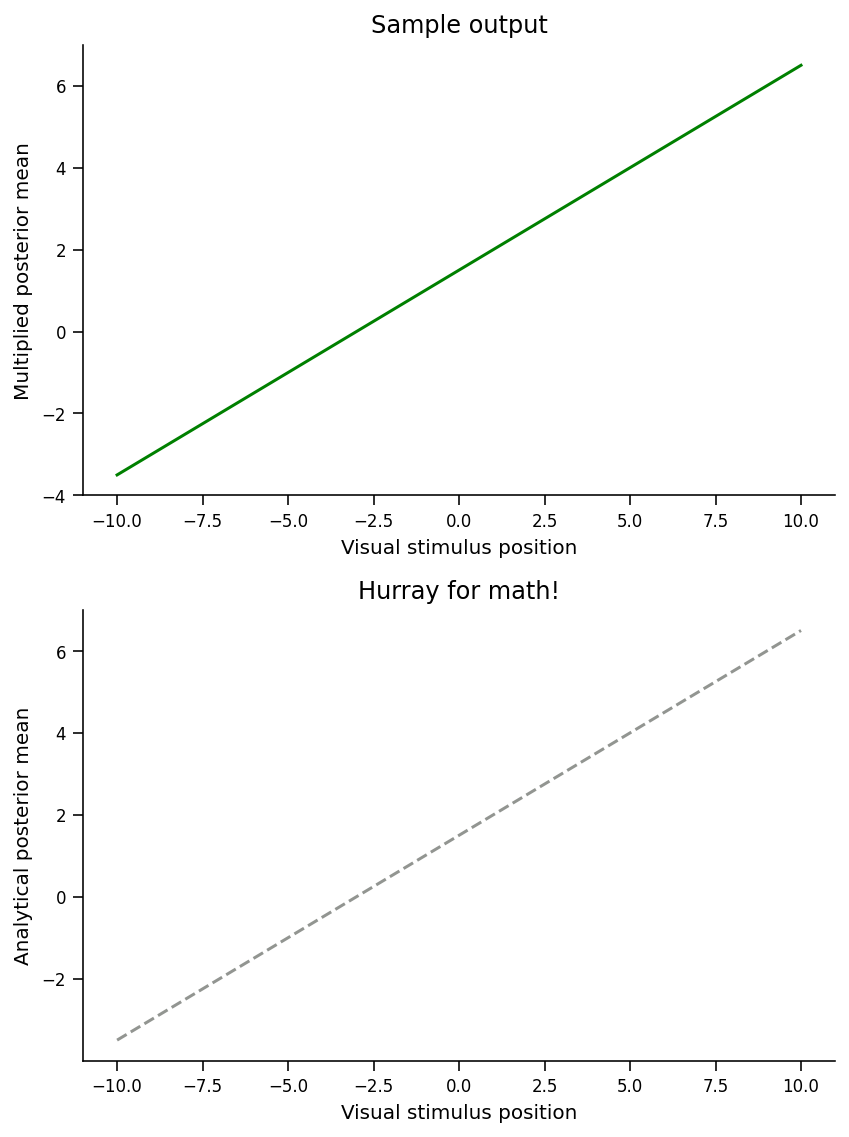

In [10]:
def compare_computational_analytical_means():
  x = np.arange(-10, 11, 0.1)

  # Fixed auditory likelihood
  mu_auditory = 3
  sigma_auditory = 1.5
  likelihood = my_gaussian(x, mu_auditory, sigma_auditory)

  # Varying visual prior
  mu_visuals = np.linspace(-10, 10)
  sigma_visual = 1.5

  # Accumulate results here
  mus_by_integration = []
  mus_analytical = []

  for mu_visual in mu_visuals:
    prior = my_gaussian(x, mu_visual, sigma_visual)
    posterior = compute_posterior_pointwise(prior, likelihood)

    ############################################################################
    ## Add code that will find the posterior mean via numerical integration
    #
    ############################################################################
    mu_integrated = np.sum(x*posterior)

    ############################################################################
    ## Add more code below that will calculate the posterior mean analytically
    #
    # Comment out the line below to test your solution
    #raise NotImplementedError("Please add code to find the mean both ways first")
    ############################################################################
    mu_analytical = (mu_visual/sigma_visual**2 + mu_auditory/sigma_auditory**2)/(1/sigma_auditory**2 + 1/sigma_visual**2)
        
    mus_by_integration.append(mu_integrated)
    mus_analytical.append(mu_analytical)

  return mu_visuals, mus_by_integration, mus_analytical


# Uncomment the lines below to visualize your results
mu_visuals, mu_computational, mu_analytical = compare_computational_analytical_means()
plot_visual(mu_visuals, mu_computational, mu_analytical)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial1_Solution_8e15215d.py)

*Example output:*

<img alt='Solution hint' align='left' width=424 height=568 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial1_Solution_8e15215d_1.png>



# Section 3: Conclusion

This tutorial introduced the Gaussian distribution and used Bayes' Theorem to combine Gaussians representing priors and likelihoods. In the next tutorial, we will use these concepts to probe how subjects integrate sensory information.



Video available at https://youtube.com/watch?v=YC8GylOAAHs


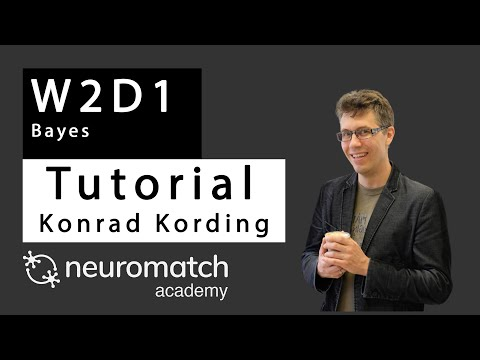

In [ ]:
#@title Video 4: Conclusion
from IPython.display import YouTubeVideo

video = YouTubeVideo(id='YC8GylOAAHs', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Bonus Section: Multimodal Priors


**Only do this if the first half-hour has not yet passed.**

The preceeding exercises used a Gaussian prior, implying that participants expected the stimulus to come from a single location, though they might not know precisely where. However, suppose the subjects actually thought that sound might come from one of two distinct locations. Perhaps they can see two speakers (and know that speakers often emit noise). 

We could model this using a Gaussian prior with a large $\sigma$ that covers both locations, but that would also make every point in between seem likely too.A better approach is to adjust the form of the prior so that it better matches the participants' experiences/expectations. In this optional exercise, we will build a bimodal (2-peaked) prior out of Gaussians and examine the resulting posterior and its peaks. 

## Exercise 3: Implement and test a multimodal prior

* Complete the `bimodal_prior` function below to create a bimodal prior, comprised of the sum of two Gaussians with means $\mu = -3$ and $\mu = 3$. Use $\sigma=1$ for both Gaussians. Be sure to normalize the result so it is a proper probability distribution. 

* In Exercise 2, we used the mean location to summarize the posterior distribution. This is not always the best choice, especially for multimodal distributions. What is the mean of our new prior? Is it a particularly likely location for the stimulus? Instead, we will use the posterior **mode** to summarize the distribution. The mode is the *location* of the most probable part of the distribution. Complete `posterior_mode` below, to find it. (Hint: `np.argmax` returns the *index* of the largest element in an array).

* Run the provided simulation and plotting code. Observe what happens to the posterior as the likelihood gets closer to the different peaks of the prior.
* Notice what happens to the posterior when the likelihood is exactly in between the two modes of the prior (i.e., $\mu_{Likelihood} = 0$)

In [ ]:
def bimodal_prior(x, mu_1=-3, sigma_1=1, mu_2=3, sigma_2=1):
  ################################################################################
  ## Finish this function so that it returns a bimodal prior, comprised of the
  # sum of two Gaussians
  #
  # Comment out the line below to test out your solution
  raise NotImplementedError("Please implement the bimodal prior")
  ################################################################################
  prior = ...

  return prior
  

def posterior_mode(x, posterior):
  ################################################################################
  ## Finish this function so that it returns the location of the mode
  #
  # Comment out the line below to test out your solution
  raise NotImplementedError("Please implement the bimodal prior")
  ################################################################################
  mode = ...

  return mode


def multimodal_simulation(x, mus_visual, sigma_visual=1):
  """
  Simulate an experiment where bimodal prior is held constant while
  a Gaussian visual likelihood is shifted across locations.
  Args:
        x:            array of points at which prior/likelihood/posterior are evaluated
        mus_visual:   array of means for the Gaussian likelihood
        sigma_visual: scalar standard deviation for the Gaussian likelihood

  Returns:
    posterior_modes:  array containing the posterior mode for each mean in mus_visual
  """

  prior = bimodal_prior(x, -3, 1, 3, 1)
  posterior_modes = []

  for mu in mus_visual:
    likelihood = my_gaussian(x, mu, 3)
    posterior = compute_posterior_pointwise(prior, likelihood)

    p_mode = posterior_mode(x, posterior)
    posterior_modes.append(p_mode)

  return posterior_modes


x = np.arange(-10, 10, 0.1)
mus = np.arange(-8, 8, 0.05)
# Uncomment the lines below to visualize your results
# posterior_modes = multimodal_simulation(x, mus, 1)
# multimodal_plot(x,
#                 bimodal_prior(x, -3, 1, 3, 1),
#                 my_gaussian(x, 1, 1),
#                 mus, posterior_modes)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial1_Solution_33ef662f.py)

*Example output:*

<img alt='Solution hint' align='left' width=424 height=568 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial1_Solution_33ef662f_1.png>

